## This notebook aims to fill the gaps from the DOSE data set

It uses the UN WDI, the Kummu data and the complementary set of countries from DOSE. 

In [1]:
import json
import io
import re
import itertools as iter
import numpy as np

# data
import pandas as pd
import geopandas as gpd
# import shapely
import duckdb
# from scipy import io as io
# import nctoolkit as nc
# import xarray as xr
# import rioxarray as rx
import glob
import ibis as ib
from ibis import _
ib.options.interactive = True

# plots

from datashader import transfer_functions as tf, reductions as rd
import pypalettes as pypal
import pydeck as pdk
from seaborn import color_palette

In [2]:
# this package cuases the whoole notebook to fail...
# from lonboard import viz

In [3]:
# The duckdb/ibis way require to either create an in-memory database at the moment of execution of the notebook, or saving the database in a file. 

In [4]:
# ddb.connect()
conn = ib.connect('duckdb://')
conn.list_tables() # empty

[]

In [5]:
# loading the spatial extension.
res = conn.raw_sql("install spatial; load spatial")
print(res)

Reading in data

With **ibis**

In [6]:
dose = conn.read_csv("../datasets/DOSE/DOSE_V2.csv",table_name="dose",all_varchar = True)

In [7]:
wdi = conn.read_csv("../datasets/WDI_CSV_2024_06_28/WDICSV.csv",table_name="wdi")

In [8]:
# boundaries = gpd.read_file("datasets/boundaries/GADM/gadm_410.gpkg")
# load boundaries data set directly into duckdb
# load extension first

res = conn.raw_sql("""INSTALL spatial;LOAD spatial;""")

In [9]:

conn.raw_sql("""CREATE OR REPLACE TABLE boundaries AS SELECT * FROM st_read("../datasets/boundaries/GADM/gadm_410.gpkg");""")

# alternative method
# conn.read_geo("datasets/boundaries/GADM/gadm_410.gpkg", table_name="boundaries")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
boundaries = conn.table("boundaries")

In [11]:
# how to name tables properly ?
conn.list_tables()

['boundaries', 'dose', 'wdi']

In [12]:
# wb_countries = gpd.read_file("datasets/boundaries/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp")

### Inspection

In [13]:
dose.head()

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region ┃ GID_0  ┃ GID_1   ┃ year   ┃ grp_lcu     ┃ pop    ┃ grp_pc_lcu ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ PPP         ┃ StructChange ┃ version ┃ T_a         ┃ P_a         ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string │ string │ string  │ string │ string      │ string │ string     │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string      │ string       │ string  │ string      │ string      │
├─────────┼────────┼────────┼─────────┼────────┼─────────────┼────────┼────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼─────────────┼──────────────┼─────────┼─────────────┼─────────────┤
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2010   │ 49416066001 │ 151375 │ 326448     │ NULL          │ NULL           │ NULL            │ 3140.842514 │ NULL          │ NULL           │ NULL            │ 345645.9835     │ NULL               │ NULL                │ NULL                 │ 3419.068968     │ NULL               │ NULL                │ NULL                 │ 2744.075141        │ NULL                  │ NULL                   │ NULL                    │ 104.7429508 │ 94.44576693   │ 103.9364434 │ 44.19621436 │ 0            │ 2       │ 13.12376773 │ 1573.116224 │
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2011   │ 52603911678 │ 148160 │ 355048     │ NULL          │ NULL           │ NULL            │ 3518.986662 │ NULL          │ NULL           │ NULL            │ 367423.0111     │ NULL               │ NULL                │ NULL                 │ 3752.327886     │ NULL               │ NULL                │ NULL                 │ 2916.962438        │ NULL                  │ NULL                   │ NULL                    │ 113.2074664 │ 96.63194446   │ 100.8949547 │ 43.85768488 │ 0            │ 2     

In [123]:
dose.filter(_.country=="Ireland").head(3)#.count()

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region ┃ gid_0  ┃ gid_1   ┃ year   ┃ grp_lcu     ┃ pop    ┃ grp_pc_lcu  ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ ppp      ┃ struct_change ┃ version ┃ t_a         ┃ p_a         ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string │ string │ string  │ string │ string      │ string │ string      │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string   │ string        │ string  │ string      │ string      │
├─────────┼────────┼────────┼─────────┼────────┼─────────────┼────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼──────────┼───────────────┼─────────┼─────────────┼─────────────┤
│ Ireland │ Carlow │ IRL    │ IRL.1_1 │ 1995   │ 398313875.4 │ 39479  │ 10089.25949 │ NULL          │ NULL           │ NULL            │ 12739.32373 │ NULL          │ NULL           │ NULL            │ 16779.57505     │ NULL               │ NULL                │ NULL                 │ 18557.45882     │ NULL               │ NULL                │ NULL                 │ 18609.66925        │ NULL                  │ NULL                   │ NULL                    │ 23.71212508 │ 60.12821814   │ 0.791977636 │ 0.801377 │ 0             │ 1       │ 10.16869158 │ 829.0329783 │
│ Ireland │ Carlow │ IRL    │ IRL.1_1 │ 1996   │ 426266829.9 │ 40310  │ 10574.71669 │ NULL          │ NULL           │ NULL            │ 13324.62109 │ NULL          │ NULL           │ NULL            │ 17191.81706     │ NULL               │ NULL                │ NULL                 │ 19061.0635      │ NULL               │ NULL                │ NULL                 │ 19066.87317        │ NULL                  │ NULL                   │ NULL                    │ 25.99313277 │ 61.5101746    │ 0.793622319 │ 0.80757  │ 0             │ 1       │ 9.0

In [14]:
wdi.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ Country Name                ┃ Country Code ┃ Indicator Name                                                                   ┃ Indicator Code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000      ┃ 2001      ┃ 2002      ┃ 2003      ┃ 2004      ┃ 2005      ┃ 2006      ┃ 2007      ┃ 2008      ┃ 2009      ┃ 2010      ┃ 2011      ┃ 2012      ┃ 2013      ┃ 2014      ┃ 2015      ┃ 2016      ┃ 2017      ┃ 2018      ┃ 2019      ┃ 2020      ┃ 2021      ┃ 2022      ┃ 2023    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ string                      │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64 │
├─────────────────────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────

In [15]:
boundaries.head()

┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ UID   ┃ GID_0  ┃ NAME_0      ┃ VARNAME_0 ┃ GID_1   ┃ NAME_1     ┃ VARNAME_1 ┃ NL_NAME_1 ┃ ISO_1  ┃ HASC_1 ┃ CC_1   ┃ TYPE_1  ┃ ENGTYPE_1 ┃ VALIDFR_1 ┃ GID_2     ┃ NAME_2    ┃ VARNAME_2 ┃ NL_NAME_2 ┃ HASC_2   ┃ CC_2   ┃ TYPE_2    ┃ ENGTYPE_2 ┃ VALIDFR_2 ┃ GID_3  ┃ NAME_3 ┃ VARNAME_3 ┃ NL_NAME_3 ┃ HASC_3 ┃ CC_3   ┃ TYPE_3 ┃ ENGTYPE_3 ┃ VALIDFR_3 ┃ GID_4  ┃ NAME_4 ┃ VARNAME_4 ┃ CC_4   ┃ TYPE_4 ┃ ENGTYPE_4 ┃ VALIDFR_4 ┃ GID_5  ┃ NAME_5 ┃ CC_5   ┃ TYPE_5 ┃ ENGTYPE_5 ┃ GOVERNEDBY ┃ SOVEREIGN   ┃ DISPUTEDBY ┃ REGION ┃ VARREGION ┃ COUNTRY     ┃ CONTINENT ┃ SUBCONT ┃ geom                                                                             ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ string │ string      │ string    │ string  │ string     │ string    │ string    │ string │ string │ string │ string  │ string    │ string    │ string    │ string    │ string    │ string    │ string   │ string │ string    │ string    │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string    │ string    │ string │ string │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string │ string    │ string     │ string      │ string     │ string │ string    │ string      │ string    │ string  │ geospatial:geometry                                                              │
├───────┼────────┼─────────────┼───────────┼─────────┼────────────┼───────────┼───────────┼────────┼────────┼────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼──────────┼────────┼───────────┼───────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼────────────┼─────────────┼────────────┼────────┼───────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     1 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD  │ ~      │ Velayat │ Province  │ Unknown   │ AFG.1.1_1 │ Baharak   │ ~         │ ~         │ AF.BD.BA │ ~      │ Wuleswali │ District  │ Unknown   │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~         │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~      │ ~         │ ~          │ Afghanistan │ ~          │ ~      │ ~         │ Afghanistan │ Asia      │ ~       │ <MULTIPOLYGON (((71.411 36.557, 71.41 36.552, 71.396 36.555, 71.374 36.555, ...> │
│     2 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │

In [16]:
# boundaries_names = [x.lower() for x in boundaries.columns]
# boundaries_names_dict = {old:new for (old,new) in zip(boundaries.columns,boundaries_names)}

In [17]:
# boundaries.rename(columns = boundaries_names_dict,inplace=True)

# for duckdb backend
# boundaries = boundaries.rename("snake_case")

In [18]:
# renaming columns the IBIS way, see below
# new_names = [x.lower().replace(" ", "_") for x in wdi.columns]

# renaming = {old : new for (old,new) in zip(wdi.columns,new_names) if old != new}

##### Changing column names for easier manipulation

In [19]:
# cool function from ibis, no need for the previous cells, althought the python dict comprehension method is cool as well.
wdi = wdi.rename("snake_case")
dose = dose.rename("snake_case")
boundaries = boundaries.rename("snake_case")

In [20]:
wdi.columns

['country_name',
 'country_code',
 'indicator_name',
 'indicator_code',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023']

In [21]:
dose.columns

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu',
 'man_grp_pc_lcu',
 'serv_grp_pc_lcu',
 'grp_pc_usd',
 'ag_grp_pc_usd',
 'man_grp_pc_usd',
 'serv_grp_pc_usd',
 'grp_pc_lcu_2015',
 'ag_grp_pc_lcu_2015',
 'man_grp_pc_lcu_2015',
 'serv_grp_pc_lcu_2015',
 'grp_pc_usd_2015',
 'ag_grp_pc_usd_2015',
 'man_grp_pc_usd_2015',
 'serv_grp_pc_usd_2015',
 'grp_pc_lcu2015_usd',
 'ag_grp_pc_lcu2015_usd',
 'man_grp_pc_lcu2015_usd',
 'serv_grp_pc_lcu2015_usd',
 'cpi_2015',
 'deflator_2015',
 'fx',
 'ppp',
 'struct_change',
 'version',
 't_a',
 'p_a']

In [22]:
boundaries.columns

['uid',
 'gid_0',
 'name_0',
 'varname_0',
 'gid_1',
 'name_1',
 'varname_1',
 'nl_name_1',
 'iso_1',
 'hasc_1',
 'cc_1',
 'type_1',
 'engtype_1',
 'validfr_1',
 'gid_2',
 'name_2',
 'varname_2',
 'nl_name_2',
 'hasc_2',
 'cc_2',
 'type_2',
 'engtype_2',
 'validfr_2',
 'gid_3',
 'name_3',
 'varname_3',
 'nl_name_3',
 'hasc_3',
 'cc_3',
 'type_3',
 'engtype_3',
 'validfr_3',
 'gid_4',
 'name_4',
 'varname_4',
 'cc_4',
 'type_4',
 'engtype_4',
 'validfr_4',
 'gid_5',
 'name_5',
 'cc_5',
 'type_5',
 'engtype_5',
 'governedby',
 'sovereign',
 'disputedby',
 'region',
 'varregion',
 'country',
 'continent',
 'subcont',
 'geom']

##### Country codes in the data sets

In [23]:
wdi_countries = np.unique(wdi.country_code.__array__()).tolist()

In [24]:
len(wdi_countries)

266

In [25]:
boundary_countries = conn.sql("Select distinct(gid_0) from boundaries;").to_pandas().iloc[:,0].to_list()
len(boundary_countries)

263

In [26]:
[x for x in wdi_countries if x in boundary_countries]

['ABW',
 'AFG',
 'AGO',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASM',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BIH',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FRA',
 'FRO',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GRL',
 'GTM',
 'GUM',
 'GUY',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAF',
 'MAR',
 'MCO',
 'MDA',
 'MDG',
 'MDV',
 'MEX',
 'MHL',
 'MKD',


In [27]:
dose_countries = list(dose.gid_0.to_pandas().unique())
dose_countries

['ALB',
 'ARG',
 'AUS',
 'AUT',
 'AZE',
 'BHS',
 'BLR',
 'BEL',
 'BOL',
 'BIH',
 'BRA',
 'BGR',
 'CAN',
 'CHL',
 'CHN',
 'COL',
 'HRV',
 'CZE',
 'DNK',
 'ECU',
 'EGY',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GEO',
 'DEU',
 'GRC',
 'GTM',
 'HND',
 'HUN',
 'IND',
 'IDN',
 'IRN',
 'IRL',
 'ITA',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'LAO',
 'LVA',
 'LTU',
 'MKD',
 'MYS',
 'MEX',
 'MNG',
 'MAR',
 'MOZ',
 'NPL',
 'NLD',
 'ANT',
 'NZL',
 'NGA',
 'NOR',
 'PAK',
 'PAN',
 'PRY',
 'PER',
 'PHL',
 'POL',
 'PRT',
 'ROU',
 'RUS',
 'SRB',
 'SVK',
 'SVN',
 'ZAF',
 'KOR',
 'ESP',
 'LKA',
 'SWE',
 'CHE',
 'TZA',
 'THA',
 'TUR',
 'ARE',
 'GBR',
 'USA',
 'UKR',
 'URY',
 'UZB',
 'VNM']

## Missing regions
Determining the missing regions from DOSE using the 3 letter country codes compared to the equivalent variable in WDI indicators

In [28]:
missing_regions = [x for x in wdi_countries if x not in dose_countries and x in boundary_countries]

In [29]:
len(missing_regions)

131

In [30]:
missing_regions

['ABW',
 'AFG',
 'AGO',
 'AND',
 'ARM',
 'ASM',
 'ATG',
 'BDI',
 'BEN',
 'BFA',
 'BGD',
 'BHR',
 'BLZ',
 'BMU',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'DJI',
 'DMA',
 'DOM',
 'DZA',
 'ERI',
 'FJI',
 'FRO',
 'FSM',
 'GAB',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRD',
 'GRL',
 'GUM',
 'GUY',
 'HTI',
 'IMN',
 'IRQ',
 'ISL',
 'ISR',
 'JAM',
 'JOR',
 'KHM',
 'KIR',
 'KNA',
 'KWT',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LSO',
 'LUX',
 'MAF',
 'MCO',
 'MDA',
 'MDG',
 'MDV',
 'MHL',
 'MLI',
 'MLT',
 'MMR',
 'MNE',
 'MNP',
 'MRT',
 'MUS',
 'MWI',
 'NAM',
 'NCL',
 'NER',
 'NIC',
 'NRU',
 'OMN',
 'PLW',
 'PNG',
 'PRI',
 'PRK',
 'PSE',
 'PYF',
 'QAT',
 'RWA',
 'SAU',
 'SDN',
 'SEN',
 'SGP',
 'SLB',
 'SLE',
 'SLV',
 'SMR',
 'SOM',
 'SSD',
 'STP',
 'SUR',
 'SWZ',
 'SXM',
 'SYC',
 'SYR',
 'TCA',
 'TCD',
 'TGO',
 'TJK',
 'TKM',
 'TLS',
 'TON',
 'TTO',
 'TUN',
 'TUV',
 'UGA',
 'VCT',
 'VEN',
 'VGB',


### WDI of interest

getting the variables of interest from the WDI index for the missing countries in the DOSE data set.

In [31]:
# should not be null
wdi.filter(_.country_code.isin(missing_regions)).head(3)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ country_name ┃ country_code ┃ indicator_name                                                                   ┃ indicator_code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000    ┃ 2001    ┃ 2002    ┃ 2003    ┃ 2004    ┃ 2005    ┃ 2006    ┃ 2007    ┃ 2008    ┃ 2009    ┃ 2010    ┃ 2011    ┃ 2012    ┃ 2013    ┃ 2014    ┃ 2015    ┃ 2016    ┃ 2017    ┃ 2018    ┃ 2019    ┃ 2020    ┃ 2021    ┃ 2022    ┃ 2023    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ string       │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │
├──────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ Algeria      │ DZA          │ Access to clean fuels and technologies for cooking (% of population)             │ EG.CFT.ACC

## Indicators 

### WDI

More on the indicators considered from the wdi website : https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators

#### Agriculture, forestry, and fishing, value added (% of GDP)

Agriculture corresponds to ISIC divisions 1-5 and includes forestry, hunting, and fishing, as well as cultivation of crops and livestock production. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

#### Industry (including construction), value added (% of GDP)

Industry corresponds to ISIC divisions 10-45 and includes manufacturing (ISIC divisions 15-37). It comprises value added in mining, manufacturing (also reported as a separate subgroup), construction, electricity, water, and gas. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

#### Manufacturing, value added (% of GDP)

Manufacturing refers to industries belonging to ISIC divisions 15-37. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

#### Services, value added (% of GDP)

Services correspond to ISIC divisions 50-99 and they include value added in wholesale and retail trade (including hotels and restaurants), transport, and government, financial, professional, and personal services such as education, health care, and real estate services. Also included are imputed bank service charges, import duties, and any statistical discrepancies noted by national compilers as well as discrepancies arising from rescaling. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The industrial origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3 or 4.

### <font color='green'>Manufacturing is included in construction !!!</font>


### DOSE

<!-- ![Dose ISIC classification](../img/dose_isic_table.png) -->
<center>
<img src="../img/dose_isic_table.png" width="50%">
</center>

<!-- # from IPython.display import Image
# Image(filename="../img/dose_isic_table.png", width=700) -->

### Remarks

* The ISIC divisions 46-49 (inclusive) seem not to be covered in WDI, the are in the *services* category in DOSE.
* In order to match with DOSE, the industry variable from WDI (which includes manufacturing) is renamed into *manufacturing* later on.

In [32]:
indicators = list(wdi.indicator_name.to_pandas().unique())
indicators

['Access to clean fuels and technologies for cooking (% of population)',
 'Access to clean fuels and technologies for cooking, rural (% of rural population)',
 'Access to clean fuels and technologies for cooking, urban (% of urban population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of

In [33]:
# subsetting the variables with relevant currency as constant 2015 values
# [x for x in indicators if re.search(string=x,pattern="constant 2015 US\\$")]
[x for x in indicators if re.search(string=x,pattern="\\% of GDP")]

['Agriculture, forestry, and fishing, value added (% of GDP)',
 'Broad money (% of GDP)',
 'Central government debt, total (% of GDP)',
 'Claims on other sectors of the domestic economy (% of GDP)',
 'Coal rents (% of GDP)',
 'Current account balance (% of GDP)',
 'Current health expenditure (% of GDP)',
 'Domestic credit provided by financial sector (% of GDP)',
 'Domestic credit to private sector (% of GDP)',
 'Domestic credit to private sector by banks (% of GDP)',
 'Domestic general government health expenditure (% of GDP)',
 'Expense (% of GDP)',
 'Exports of goods and services (% of GDP)',
 'External balance on goods and services (% of GDP)',
 'Final consumption expenditure (% of GDP)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Foreign direct investment, net outflows (% of GDP)',
 'Forest rents (% of GDP)',
 'General government final consumption expenditure (% of GDP)',
 'Government expenditure on education, total (% of GDP)',
 'Government expenditure per student, p

In [34]:
# manually getting the useful variables and storing in a dict with simplified names.
indicators_of_intereset_perc = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_perc" : "Industry (including construction), value added (% of GDP)",
    # "manufacturing_perc" : "Manufacturing, value added (% of GDP)",
    "services_perc" : "Services, value added (% of GDP)",
    "agriculture_perc" : "Agriculture, forestry, and fishing, value added (% of GDP)",
}

indicators_of_intereset_usd_2015 = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_usd_2015" : "Industry (including construction), value added (constant 2015 US$)",
    # "manufacturing_usd_2015" : "Manufacturing, value added (constant 2015 US$)",
    "services_usd_2015" : "Services, value added (constant 2015 US$)",
    "agriculture_usd_2015" : "Agriculture, forestry, and fishing, value added (constant 2015 US$)",
    
}


In [35]:
# select here which dict of indicators to use
indicators_of_intereset = indicators_of_intereset_usd_2015

In [36]:
### A year of interest:

year = 2015

if str(year) not in wdi.columns:
    raise ValueError("No such year ({}) in WDI data".format(year))

In [37]:
wdi_cols = ["country_name","country_code","indicator_name","indicator_code",str(year)]

# _.country_code.isin(missing_regions),

wdi_of_interest = wdi.select(wdi_cols).filter(_.indicator_name.isin(indicators_of_intereset.values()))

In [38]:
# get the data of interest into a pandas df
wdi_df = wdi_of_interest.to_pandas()

In [40]:
print(wdi_df.shape)
wdi_df.head(5)

(1330, 5)


,country_name,country_code,indicator_name,indicator_code,2015
0,IDA only,IDX,"Industry (including construction), value added...",NV.IND.TOTL.KD,2.776574e+11
1,IDA only,IDX,"Services, value added (constant 2015 US$)",NV.SRV.TOTL.KD,5.171372e+11
2,IDA total,IDA,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KD,4.494375e+11
3,IDA total,IDA,GDP (constant 2015 US$),NY.GDP.MKTP.KD,2.147696e+12
4,IDA total,IDA,GDP per capita (constant 2015 US$),NY.GDP.PCAP.KD,1.360962e+03


### Missing countries geometries
From the data set on boundaries, get the geometries for the missing countries from dose.

#### The geometry bit is not used down the line currently


In [41]:
boundaries.head(3)

┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ uid   ┃ gid_0  ┃ name_0      ┃ varname_0 ┃ gid_1   ┃ name_1     ┃ varname_1 ┃ nl_name_1 ┃ iso_1  ┃ hasc_1 ┃ cc_1   ┃ type_1  ┃ engtype_1 ┃ validfr_1 ┃ gid_2     ┃ name_2   ┃ varname_2 ┃ nl_name_2 ┃ hasc_2   ┃ cc_2   ┃ type_2    ┃ engtype_2 ┃ validfr_2 ┃ gid_3  ┃ name_3 ┃ varname_3 ┃ nl_name_3 ┃ hasc_3 ┃ cc_3   ┃ type_3 ┃ engtype_3 ┃ validfr_3 ┃ gid_4  ┃ name_4 ┃ varname_4 ┃ cc_4   ┃ type_4 ┃ engtype_4 ┃ validfr_4 ┃ gid_5  ┃ name_5 ┃ cc_5   ┃ type_5 ┃ engtype_5 ┃ governedby ┃ sovereign   ┃ disputedby ┃ region ┃ varregion ┃ country     ┃ continent ┃ subcont ┃ geom                                                                             ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ string │ string      │ string    │ string  │ string     │ string    │ string    │ string │ string │ string │ string  │ string    │ string    │ string    │ string   │ string    │ string    │ string   │ string │ string    │ string    │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string    │ string    │ string │ string │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string │ string    │ string     │ string      │ string     │ string │ string    │ string      │ string    │ string  │ geospatial:geometry                                                              │
├───────┼────────┼─────────────┼───────────┼─────────┼────────────┼───────────┼───────────┼────────┼────────┼────────┼─────────┼───────────┼───────────┼───────────┼──────────┼───────────┼───────────┼──────────┼────────┼───────────┼───────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼────────────┼─────────────┼────────────┼────────┼───────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     1 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD  │ ~      │ Velayat │ Province  │ Unknown   │ AFG.1.1_1 │ Baharak  │ ~         │ ~         │ AF.BD.BA │ ~      │ Wuleswali │ District  │ Unknown   │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~         │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~      │ ~         │ ~          │ Afghanistan │ ~          │ ~      │ ~         │ Afghanistan │ Asia      │ ~       │ <MULTIPOLYGON (((71.411 36.557, 71.41 36.552, 71.396 36.555, 71.374 36.555, ...> │
│     2 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD

In [42]:
missing_geoms_ = boundaries.filter(_.gid_0.isin(missing_regions)).alias("missing_geoms_")

In [43]:
missing_geoms_.head(3)

┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ uid   ┃ gid_0  ┃ name_0      ┃ varname_0 ┃ gid_1   ┃ name_1     ┃ varname_1 ┃ nl_name_1 ┃ iso_1  ┃ hasc_1 ┃ cc_1   ┃ type_1  ┃ engtype_1 ┃ validfr_1 ┃ gid_2     ┃ name_2   ┃ varname_2 ┃ nl_name_2 ┃ hasc_2   ┃ cc_2   ┃ type_2    ┃ engtype_2 ┃ validfr_2 ┃ gid_3  ┃ name_3 ┃ varname_3 ┃ nl_name_3 ┃ hasc_3 ┃ cc_3   ┃ type_3 ┃ engtype_3 ┃ validfr_3 ┃ gid_4  ┃ name_4 ┃ varname_4 ┃ cc_4   ┃ type_4 ┃ engtype_4 ┃ validfr_4 ┃ gid_5  ┃ name_5 ┃ cc_5   ┃ type_5 ┃ engtype_5 ┃ governedby ┃ sovereign   ┃ disputedby ┃ region ┃ varregion ┃ country     ┃ continent ┃ subcont ┃ geom                                                                             ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ string │ string      │ string    │ string  │ string     │ string    │ string    │ string │ string │ string │ string  │ string    │ string    │ string    │ string   │ string    │ string    │ string   │ string │ string    │ string    │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string    │ string    │ string │ string │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string │ string    │ string     │ string      │ string     │ string │ string    │ string      │ string    │ string  │ geospatial:geometry                                                              │
├───────┼────────┼─────────────┼───────────┼─────────┼────────────┼───────────┼───────────┼────────┼────────┼────────┼─────────┼───────────┼───────────┼───────────┼──────────┼───────────┼───────────┼──────────┼────────┼───────────┼───────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼────────────┼─────────────┼────────────┼────────┼───────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     1 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD  │ ~      │ Velayat │ Province  │ Unknown   │ AFG.1.1_1 │ Baharak  │ ~         │ ~         │ AF.BD.BA │ ~      │ Wuleswali │ District  │ Unknown   │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~         │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~      │ ~         │ ~          │ Afghanistan │ ~          │ ~      │ ~         │ Afghanistan │ Asia      │ ~       │ <MULTIPOLYGON (((71.411 36.557, 71.41 36.552, 71.396 36.555, 71.374 36.555, ...> │
│     2 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD

## WDI data transformed
pivoting the data WDI data

In [44]:
wdi_df_var = wdi_df.pivot(columns=["indicator_name",],values=[str(year)],index=["country_name","country_code"]).reset_index()

In [45]:
wdi_df_var.rename(columns={v:k for (k,v) in indicators_of_intereset.items()} # inverting the indicators of interest to rename columns
                  ,inplace=True)

In [46]:
wdi_df_var.columns = [x[1] if x[1]!='' else x[0] for x in wdi_df_var.columns]

In [47]:
wdi_df_var.columns = [x.replace("industry", "manufacturing") if re.search(string=x,pattern="industry_") else x for x in wdi_df_var.columns]

In [48]:
wdi_df_var.head(3)

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Africa Eastern and Southern,AFE,1.155662e+11,8.992957e+11,1498.805084,2.265433e+11,4.854947e+11
2,Africa Western and Central,AFW,1.557361e+11,7.693673e+11,1882.518808,1.767360e+11,4.108969e+11


In [49]:
# without 'manufacturing' it makes a bit more sense:

indicator_columns = [x for x in wdi_df_var.columns if re.search(string=x,pattern="(services_)|(agriculture_)|(manufacturing_)")]
indicator_columns

['agriculture_usd_2015', 'manufacturing_usd_2015', 'services_usd_2015']

<Axes: >

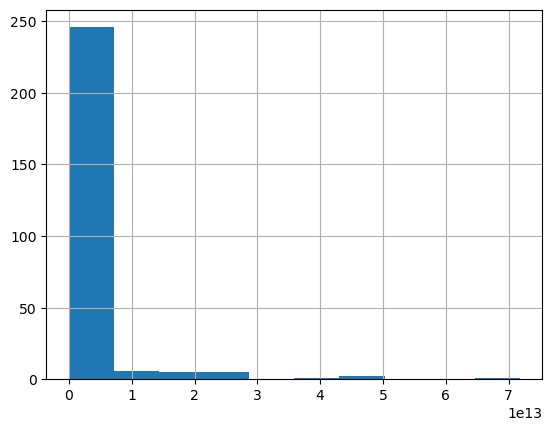

In [272]:

wdi_df_var[indicator_columns].sum(axis=1).apply(np.log1p).hist()

### Retrieving the geometries
From duckdb we get the geometries of the missing countries with geometry as well known text. currently, that the only method for extracting geometries from duckdb that seems to work, although with some exceptions when goemetreis are very detailed and exceed the string length limit. 

#### Trying to find workarounds for that.


In [ ]:

# missing_geom = (
#     missing_geoms_
#         .mutate(geom_wkt = _.geom.as_text())
#         .select(_.gid_0,_.geom_wkt)
#     ).to_pandas()

# # creating back the geometry
# missing_geom["geometry"] = gpd.GeoSeries.from_wkt(missing_geom["geom_wkt"])
# # mking a geodf
# missing_geoms = gpd.GeoDataFrame(missing_geom,geometry="geometry",crs="EPSG:4326")


In [ ]:
# # # ibis geospatial tests 
# # import ibis as ib
# # ib.options.interactive = True
# t = ib.examples.zones.fetch()
# t.head()
# t.geom.area()
# t.geom.type()
# # ib.get_backend()

In [55]:

# merging with the WDI data selected variables

# wdi_gdf= missing_geoms.merge(wdi_df_var,left_on="gid_0",right_on="country_code")

# this is relevant when adding the spatial data, the copy operation is left here.
wdi_gdf = wdi_df_var.copy()
wdi_gdf.head()

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Africa Eastern and Southern,AFE,1.155662e+11,8.992957e+11,1498.805084,2.265433e+11,4.854947e+11
2,Africa Western and Central,AFW,1.557361e+11,7.693673e+11,1882.518808,1.767360e+11,4.108969e+11
3,Albania,ALB,2.252344e+09,1.138685e+10,3952.803574,2.478198e+09,5.270341e+09
4,Algeria,DZA,1.974833e+10,1.874939e+11,4741.499770,6.141643e+10,9.770374e+10


In [ ]:
# # removing the wkt column, it can cause problems down the line. 
# wdi_gdf = wdi_gdf.loc[:,wdi_gdf.columns.difference(["geom_wkt"])]

In [ ]:
# # grouping all admin1 level entities back into admin 0, for country geometries, faster to plot
# wdi_country = wdi_gdf.groupby(by="gid_0",sort=True).reset_index(drop=False)

In [ ]:
# wdi_country.crs

In [ ]:
# print(wdi_country.shape)
# wdi_country.head(3)

In [ ]:
# # drop a row if it's only NA
# wdi_country.dropna(inplace=True,how="all") 

In [ ]:
# # further simplifying the geometries for easier plotting
# wdi_country["simple_geom"] = wdi_country["geometry"].simplify(tolerance = 0.4)

In [ ]:
# wdi_country["simple_geom"] = wdi_country.make_valid()

In [ ]:
# wdi_country_simple = wdi_country[wdi_country.columns.difference(["geometry"])].copy()

# wdi_country_simple.rename(columns={"simple_geom":"geometry"},inplace=True)

# # setting the geometry to the simple one
# wdi_country_simple.set_geometry("geometry",inplace=True)

In [ ]:
# wdi_country_simple.head(3)

In [ ]:
# viewing with geopandas explore
# wdi_country_simple.explore("services_usd_2015")

### Downscaling missing DOSE 

could be moved to another notebook.

In [ ]:
# import h3

In [ ]:
# base_res = 4

In [ ]:
# wdi_country_simple["hex"] = wdi_country_simple["geometry"].apply(h3.geo_to_cells,res = base_res)

In [ ]:
# gpd.GeoSeries(wdi_country_simple["hex"].apply(h3.cells_to_h3shape),crs="EPSG:4326").explore()

In [ ]:
# wdi_country_hex = wdi_country_simple.explode("hex").reset_index(drop=True)

In [ ]:
# wdi_country_hex

### Set up color palette for the map.

In [ ]:
# viridis = color_palette("viridis", as_cmap=True) # the sns function
# viridis

In [ ]:
# bmlunge = pypal.load_cmap("Bmlunge")
# bmlunge.N

In [ ]:
# def cmap(input, palette):
#     input = np.nan_to_num(input).tolist()
#     m = np.max(input)
#     l = palette.N
#     print("Max input : {}, palette colors : {}".format(m,l))
#     return [[int(255*j) for j in palette(int(x/m*l))] for x in input] #

In [ ]:
# unique_vals = pd.Series(wdi_country_hex["gdp"].unique())
# unique_vals

In [ ]:
# cols = cmap(np.log1p(wdi_country_hex["gdp"]),palette=bmlunge)
# wdi_country_hex["color"] = cols
# wdi_country_hex.head()

#### Deck map is broken...

In [ ]:
# viewport = pdk.data_utils.compute_view(points=compact_geo_downscaled[['x', 'y']], view_proportion=0.9)

# viewport = pdk.ViewState(longitude=0,latitude=0,zoom=2)

In [ ]:
# # Deck map showing the combined layers for each variable

# gdp_layer = pdk.Layer(
#     "PolygonLayer",
#     wdi_country_simple,
#     pickable=True,
#     extruded=False,
#     filled=True,
#     stroked=True,
#     opacity=.6,
#     get_polygons = "geometry",
#     get_fill_color = "color", #"[255*log_value/20,100,120]",
#     get_line_color= [255, 255, 255, 0],
#     line_width_min_pixels=1,
#     )


# h3_layer = pdk.Layer(
#     "H3HexagonLayer",
#     wdi_country_hex[["gdp","hex","color"]],
#     pickable=True,
#     stroked=True,
#     filled=True,
#     opacity=.5,
#     extruded=False,
#     get_hexagon="hex",
#     get_fill_color= "color", #[230, 200, 180, 255],
#     get_line_color=[0, 0, 0, 0],
#     line_width_min_pixels=1,
# )


In [ ]:
# r = pdk.Deck(layers=[h3_layer]
#             ,initial_view_state=viewport
#             ,tooltip=True
#             # ,mapbox_key="MAPBOX_API_KEY"
#             )

In [ ]:
# r.to_html("deck_maps/missing_country_var.html",iframe_height=800)

## Combining the data sets

In [56]:
# inspecting the 
dose.year.value_counts().order_by("year").to_pandas().tail(10)

,year,year_count
52,2011,1420
53,2012,1476
54,2013,1564
55,2014,1548
56,2015,1524
57,2016,1521
58,2017,1518
59,2018,1335
60,2019,1039
61,2020,354


In [57]:
dose.columns

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu',
 'man_grp_pc_lcu',
 'serv_grp_pc_lcu',
 'grp_pc_usd',
 'ag_grp_pc_usd',
 'man_grp_pc_usd',
 'serv_grp_pc_usd',
 'grp_pc_lcu_2015',
 'ag_grp_pc_lcu_2015',
 'man_grp_pc_lcu_2015',
 'serv_grp_pc_lcu_2015',
 'grp_pc_usd_2015',
 'ag_grp_pc_usd_2015',
 'man_grp_pc_usd_2015',
 'serv_grp_pc_usd_2015',
 'grp_pc_lcu2015_usd',
 'ag_grp_pc_lcu2015_usd',
 'man_grp_pc_lcu2015_usd',
 'serv_grp_pc_lcu2015_usd',
 'cpi_2015',
 'deflator_2015',
 'fx',
 'ppp',
 'struct_change',
 'version',
 't_a',
 'p_a']

In [58]:
wdi.select("country_code",*[str(i) for i in range(1960,2022,1) if str(i) in wdi.columns])

┏━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ country_code ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000      ┃ 2001      ┃ 2002      ┃ 2003      ┃ 2004      ┃ 2005      ┃ 2006      ┃ 2007      ┃ 2008      ┃ 2009      ┃ 2010      ┃ 2011      ┃ 2012      ┃ 2013      ┃ 2014      ┃ 2015      ┃ 2016      ┃ 2017      ┃ 2018      ┃ 2019      ┃ 2020      ┃ 2021      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string       │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │
├──────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ AFE          │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │ 11.525904 │ 11.850593 │ 12.175592 │ 12.551723 │ 12.924851 │ 13.347701 │ 13.804893 │ 14.226285 │ 14.644801 │ 15.136871 │ 15.592328 │ 16.005356 │ 16.466945 │ 16.877313 │ 17.401410 

#### Using the year variable assinged earlier

In [59]:
# conn.raw_sql("SUMMARIZE wdi;").df().tail(10)

In [60]:
dose_year = dose.filter(_.year==str(year)).to_pandas()

In [61]:
# due to the way na values are written in the data set, all the data had to be read as strings, changing this here.
dose_year.replace(to_replace="#N/A",value=np.nan,inplace=True)

In [62]:
dose_year.head(3)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,man_grp_pc_lcu2015_usd,serv_grp_pc_lcu2015_usd,cpi_2015,deflator_2015,fx,ppp,struct_change,version,t_a,p_a
0,Albania,Berat,ALB,ALB.1_1,2015,54691123900,136904,399485.2152,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,13.50185305,1093.56268
1,Albania,Dibër,ALB,ALB.2_1,2015,46850206200,130056,360231.0251,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,10.45442675,1175.134798
2,Albania,Durrës,ALB,ALB.3_1,2015,1.40E+11,279097,502550.8411,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,16.16559071,1047.35031


On the duckdb end all the data was stored as strings becuase the NA values were not interpretable as numeric. so converting back 


In [63]:
# have a look at the columns
dose_year.columns

Index(['country', 'region', 'gid_0', 'gid_1', 'year', 'grp_lcu', 'pop',
       'grp_pc_lcu', 'ag_grp_pc_lcu', 'man_grp_pc_lcu', 'serv_grp_pc_lcu',
       'grp_pc_usd', 'ag_grp_pc_usd', 'man_grp_pc_usd', 'serv_grp_pc_usd',
       'grp_pc_lcu_2015', 'ag_grp_pc_lcu_2015', 'man_grp_pc_lcu_2015',
       'serv_grp_pc_lcu_2015', 'grp_pc_usd_2015', 'ag_grp_pc_usd_2015',
       'man_grp_pc_usd_2015', 'serv_grp_pc_usd_2015', 'grp_pc_lcu2015_usd',
       'ag_grp_pc_lcu2015_usd', 'man_grp_pc_lcu2015_usd',
       'serv_grp_pc_lcu2015_usd', 'cpi_2015', 'deflator_2015', 'fx', 'ppp',
       'struct_change', 'version', 't_a', 'p_a'],
      dtype='object')

In [64]:
# The columns that we will use later will be multiplied, so this step is essential.

float_cols = dose_year.filter(regex="(lcu)|(usd)|(cpi)|(pop)|(year)|(T_a)|(P_a)|(PPP)|(2015)").columns.unique()

dose_year[float_cols] = dose_year[float_cols].astype(float)

## Filling population gaps in DOSE

#### Converting per capita into absolute values with the population variable.


In [140]:
dose_year.head(10)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,fx,ppp,struct_change,version,t_a,p_a,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
0,Albania,Berat,ALB,ALB.1_1,2015.0,5.469112e+10,136904.0,399485.2152,NaN,NaN,...,125.9608304,42.70570052,3,2,13.50185305,1093.56268,NaN,NaN,NaN,4.341915e+08
1,Albania,Dibër,ALB,ALB.2_1,2015.0,4.685021e+10,130056.0,360231.0251,NaN,NaN,...,125.9608304,42.70570052,3,2,10.45442675,1175.134798,NaN,NaN,NaN,3.719427e+08
2,Albania,Durrës,ALB,ALB.3_1,2015.0,1.400000e+11,279097.0,502550.8411,NaN,NaN,...,125.9608304,42.70570052,3,2,16.16559071,1047.35031,NaN,NaN,NaN,1.113524e+09
3,Albania,Elbasan,ALB,ALB.4_1,2015.0,1.000000e+11,289136.0,346548.9099,NaN,NaN,...,125.9608304,42.70570052,3,2,12.9849634,1017.524637,NaN,NaN,NaN,7.954835e+08
4,Albania,Fier,ALB,ALB.5_1,2015.0,1.690000e+11,306561.0,552703.4714,NaN,NaN,...,125.9608304,42.70570052,3,2,16.91313816,978.7869504,NaN,NaN,NaN,1.345159e+09
5,Albania,Gjirokastër,ALB,ALB.6_1,2015.0,3.430914e+10,68789.0,498759.1025,NaN,NaN,...,125.9608304,42.70570052,3,2,13.38578971,1418.661877,NaN,NaN,NaN,2.723794e+08
6,Albania,Korçë,ALB,ALB.7_1,2015.0,8.082571e+10,218809.0,369389.3336,NaN,NaN,...,125.9608304,42.70570052,3,2,10.66274768,948.6876289,NaN,NaN,NaN,6.416734e+08
7,Albania,Kukës,ALB,ALB.8_1,2015.0,2.600849e+10,81861.0,317715.3211,NaN,NaN,...,125.9608304,42.70570052,3,2,10.20104714,1194.992299,NaN,NaN,NaN,2.064808e+08
8,Albania,Lezhë,ALB,ALB.9_1,2015.0,4.751271e+10,131044.0,362570.6915,NaN,NaN,...,125.9608304,42.70570052,3,2,13.89092335,1107.796274,NaN,NaN,NaN,3.772023e+08
9,Albania,Shkodër,ALB,ALB.10_1,2015.0,7.736371e+10,211658.0,365512.8018,NaN,NaN,...,125.9608304,42.70570052,3,2,12.63849691,1324.181133,NaN,NaN,NaN,6.141886e+08


In [243]:
# filling some extra missing values of population to reconstruct the economic indicators. From sources on the net.
missing_pop = dose_year.loc[dose_year["pop"].isna(),["country","region","pop"]].copy().set_index("region")
missing_pop.head()

,country,pop
region,,
Neuquen,Argentina,NaN
Tucuman,Argentina,NaN
Mato Grosso Do Sul,Brazil,NaN
Rio De Janeiro,Brazil,NaN
Rio Grande Do Norte,Brazil,NaN


In [217]:
missing_pop["region"].to_csv("missing_pop.csv",index=False)

In [320]:
## strangely, Ireland is missing from the data, using it's census data to fill the gaps.
# https://data.gov.ie/dataset/population-classified-by-area 

# this data set : https://www.cso.ie/en/media/csoie/census/documents/saps2011files/AllThemesTablesCTY.csv

ireland = pd.read_csv("../datasets/support_data/ireland/AllThemesTablesCTY.csv"
                      ,encoding="UTF-8")
ireland.columns = [x.lower() for x in ireland.columns]
ireland.head(3)

# manually replaced Dublin City -> Dublin, Laois -> Laoighis in the data set.

# to many columns
ireland = ireland[["t1_1agett","geogdesc"]]


In [321]:
ireland.rename(columns={"t1_1agett":"pop"
                        ,"geogdesc":"region"},inplace=True)

# few cases 
tipperary_pop = ireland.loc[ireland.region.isin(["Tipperary North","Tipperary South"]),"pop"].sum()

missing_case = pd.DataFrame([{"region" : "Tipperary", "pop" : tipperary_pop}])

ireland = pd.concat([ireland,missing_case])

ireland.set_index("region",inplace=True)
ireland.head()

,pop
region,
Carlow,54612
Dublin,527612
South Dublin,265205
Fingal,273991
Dún Laoghaire-Rathdown,206261


In [324]:
missing_index = [x for x in ireland.index if x in missing_pop.index]


In [326]:
missing_pop.loc[missing_index,"pop"] = ireland.loc[missing_index,"pop"]

In [327]:
missing_pop.loc[missing_pop.country=="Ireland"].tail(3)

,country,pop
region,,
Westmeath,Ireland,86164.0
Wexford,Ireland,145320.0
Wicklow,Ireland,136640.0


In [328]:
missing_pop.reset_index(inplace=True,drop=False)
missing_pop.head()

,region,country,pop
0,Neuquen,Argentina,744592.0
1,Tucuman,Argentina,1593000.0
2,Mato Grosso Do Sul,Brazil,2833742.0
3,Rio De Janeiro,Brazil,6625849.0
4,Rio Grande Do Norte,Brazil,3302729.0


In [329]:
# Argentina
missing_pop.loc[missing_pop.region=="Neuquen","pop"] = 744_592 # statista : https://www.statista.com/statistics/1413909/population-by-group-age-gender-neuquen-argentina
missing_pop.loc[missing_pop.region=="Tucuman","pop"] = 1.593e6 # wiki

# Brasil
missing_pop.loc[missing_pop.region=="Mato Grosso Do Sul","pop"] = 2_833_742 # https://www.britannica.com/place/Mato-Grosso-do-Sul
missing_pop.loc[missing_pop.region=="Rio De Janeiro","pop"] = 6_625_849 # https://www.britannica.com/place/Rio-de-Janeiro-Brazil
missing_pop.loc[missing_pop.region=="Rio Grande Do Norte","pop"] = 3_302_729 # https://cidades.ibge.gov.br/brasil/rn/panorama
missing_pop.loc[missing_pop.region=="Rio Grande Do Sul","pop"] = 11_329_605 # https://www.ceicdata.com/en/brazil/population/population-south-rio-grande-do-sul
missing_pop.loc[missing_pop.region=="","pop"] = 541_391 # https://www.gov.nl.ca/fin/economics/eb-population/
missing_pop.loc[missing_pop.region=="Norte de Santander","pop"] = 1_617_209 # https://www.citypopulation.de/en/colombia/admin/54__norte_de_santander/

# croatia
missing_pop.loc[missing_pop.region=="Slavonskibrod-Posavina","pop"] = 130_267 # https://www.citypopulation.de/en/croatia/admin/12__brod_posavina/

# Kazakhstan
missing_pop.loc[missing_pop.region=="Aktobe","pop"] = 944_600 # https://stat.gov.kz/en/region/aktobe/
missing_pop.loc[missing_pop.region=="Atirau","pop"] = 708_500 # https://stat.gov.kz/en/region/atyrau/
missing_pop.loc[missing_pop.region=="East Kazakhstan","pop"] = 731_246 # https://www.citypopulation.de/en/kazakhstan/cities/
missing_pop.loc[missing_pop.region=="Kostanay","pop"] = 827_900 # https://stat.gov.kz/en/region/kostanay/
missing_pop.loc[missing_pop.region=="North Kazakhstan","pop"] = 540_700 # 

# south Korea
missing_pop.loc[missing_pop.region=="Gangwond-do","pop"] = 1_521_763 # https://www.citypopulation.de/en/southkorea/admin/32__gangwon_do/

# Tanzania
missing_pop.loc[missing_pop.region=="Arusha","pop"] = 2_356_255 # https://www.citypopulation.de/en/tanzania/admin/02__arusha/
missing_pop.loc[missing_pop.region=="Dar es salaam","pop"] = 8_161_231 # https://worldpopulationreview.com/cities/tanzania/dar-es-salaam
missing_pop.loc[missing_pop.region=="Dodoma","pop"] = 3_085_625 # https://www.citypopulation.de/en/tanzania/admin/01__dodoma/
missing_pop.loc[missing_pop.region=="Geita","pop"] = 2_977_608 # https://www.citypopulation.de/en/tanzania/admin/25__geita
missing_pop.loc[missing_pop.region=="Iringa","pop"] = 1_192_728 # http://www.citypopulation.de/en/tanzania/admin/11__iringa/
missing_pop.loc[missing_pop.region=="Kagera","pop"] = 2_989_299 # https://www.citypopulation.de/en/tanzania/admin/18/
missing_pop.loc[missing_pop.region=="Katavi","pop"] = 1_152_958 # https://citypopulation.de/en/tanzania/admin/23__katavi/
missing_pop.loc[missing_pop.region=="Kigoma","pop"] = 2_470_967 # https://citypopulation.de/en/tanzania/admin/
missing_pop.loc[missing_pop.region=="Kilimanjaro","pop"] = 1_861_934
missing_pop.loc[missing_pop.region=="Lindi","pop"] = 1_194_028
missing_pop.loc[missing_pop.region=="Manyara","pop"] = 1_892_502
missing_pop.loc[missing_pop.region=="Mara","pop"] = 2_372_015
missing_pop.loc[missing_pop.region=="Mbeya","pop"] = 2_343_754
missing_pop.loc[missing_pop.region=="Morogoro","pop"] = 3_197_104
missing_pop.loc[missing_pop.region=="Mtwara","pop"] = 1_634_947
missing_pop.loc[missing_pop.region=="Mwanza","pop"] = 3_699_872
missing_pop.loc[missing_pop.region=="Njombe","pop"] = 889_946
missing_pop.loc[missing_pop.region=="Pwani","pop"] = 2_024_947
missing_pop.loc[missing_pop.region=="Rukwa","pop"] = 1_540_519
missing_pop.loc[missing_pop.region=="Ruvuma","pop"] = 1_848_794
missing_pop.loc[missing_pop.region=="Shinyanga","pop"] = 2_241_299
missing_pop.loc[missing_pop.region=="Singida","pop"] = 2_008_058
missing_pop.loc[missing_pop.region=="Tabora","pop"] = 3_391_679
missing_pop.loc[missing_pop.region=="Tanga","pop"] = 2_615_597

# Ukraine
missing_pop.loc[missing_pop.region=="Dnipropetrovsk","pop"] = 1_145_065
missing_pop.loc[missing_pop.region=="Kyiv City","pop"] = 2_952_301 # https://www.citypopulation.de/en/ukraine/kievcity/

In [331]:
# no 'fx' is na
# dose_year[dose_year["fx"].isna()]
# NA for gid_0=="ANT"
# dose_year[dose_year["deflator_2015"].isna()]
# # dose_year[dose_year.gid_0=="ANT"]
# lcu_vars = [x for x in dose_year.columns if re.search(string=x,pattern="_lcu")]
# dose_year[lcu_vars].isna() 

### Putting the missing populations back in

In [332]:
dose_year.set_index("region",inplace=True)

In [333]:
# yeahhhh
dose_year.loc[missing_pop.index,"pop"] = missing_pop["pop"]

In [334]:
dose_year.reset_index(inplace=True,drop=False)

## Filling lcu gaps
Computing grp values in lcu for missing populations.

In [335]:
dose_year["agriculture_usd_2015"] = dose_year["ag_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["manufacturing_usd_2015"] = dose_year["man_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["services_usd_2015"] = dose_year["serv_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["grp_usd_2015"] = dose_year["grp_pc_usd_2015"]*dose_year["pop"]

In [336]:
# the light version is reduced to the variables of interest only. This includes a specific year, sector and total gdp(grp) values.
dose_light = dose_year[["country","gid_0","gid_1","grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"]].copy()

In [337]:
# WDI is also reduced to the essential in order to concat the data sets later on.
# this step could be done at an earlier stage as well to avoid redundancy.
wdi_country_simple = wdi_gdf.loc[:,~wdi_gdf.columns.isin(["country_code","geometry","gdp_cap"])]

## Combining 
Using the fact that columns are named the same.

#### The column names should match

In [338]:
dose_light.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN


In [339]:
wdi_country_simple.head(3)

,country,agriculture_usd_2015,grp_usd_2015,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,3.948217e+09,1.913422e+10,4.233263e+09,1.018616e+10
1,Africa Eastern and Southern,1.155662e+11,8.992957e+11,2.265433e+11,4.854947e+11
2,Africa Western and Central,1.557361e+11,7.693673e+11,1.767360e+11,4.108969e+11


In [340]:
if wdi_country_simple.columns.difference(dose_light.columns).__len__()!=0:
    raise Exception("Some columns don't match in the data sets, concatenation behaviour will be unexpected.")

In [341]:
dose_light_combined = pd.concat([dose_light,wdi_country_simple],axis=0).reset_index(drop=True)

In [342]:
dose_light_combined.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN


### filling admin 1 gaps in dose with WDI

The process : 
when a country in DOSE has missing sectorial values, take the proportion of per sector gdp in WDI for the national scale and replace in DOSE.

In [343]:
incomplete_dose = list(dose_light.loc[dose_light[["services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015","grp_usd_2015"]].isna().any(axis=1),"gid_0"].unique())

In [344]:
incomplete_dose

['ALB',
 'AZE',
 'BIH',
 'CAN',
 'IRL',
 'KEN',
 'KGZ',
 'MOZ',
 'ANT',
 'PRY',
 'PHL',
 'TZA',
 'UKR',
 'UZB']

In [345]:
wdi_df_var.head(10)

,country,country_code,agriculture_usd_2015,grp_usd_2015_,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Africa Eastern and Southern,AFE,1.155662e+11,8.992957e+11,1498.805084,2.265433e+11,4.854947e+11
2,Africa Western and Central,AFW,1.557361e+11,7.693673e+11,1882.518808,1.767360e+11,4.108969e+11
3,Albania,ALB,2.252344e+09,1.138685e+10,3952.803574,2.478198e+09,5.270341e+09
4,Algeria,DZA,1.974833e+10,1.874939e+11,4741.499770,6.141643e+10,9.770374e+10
5,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN
6,Andorra,AND,1.432381e+07,2.789881e+09,38885.530322,2.784655e+08,2.194727e+09
7,Angola,AGO,8.255567e+09,9.049642e+10,3217.339240,3.794795e+10,4.403546e+10
8,Antigua and Barbuda,ATG,2.078148e+07,1.437756e+09,15985.541139,2.289630e+08,1.050844e+09
9,Arab World,ARB,1.443487e+11,2.544136e+12,6258.607227,1.032044e+12,1.355492e+12


In [346]:
wdi_df_var.rename(columns={"grp_usd_2015" : "grp_usd_2015_"},inplace=True)

In [347]:
# This data frame name is a bit confusing, but it contains WDI data missing from dose.
dose_missing_df = wdi_df_var.loc[wdi_df_var.country_code.isin(incomplete_dose)].copy()

In [348]:
# should not be empty
dose_missing_df.tail(3)

,country,country_code,agriculture_usd_2015,grp_usd_2015_,gdp_cap,manufacturing_usd_2015,services_usd_2015
238,Tanzania,TZA,1.268127e+10,4.741392e+10,929.799805,1.161041e+10,1.917000e+10
250,Ukraine,UKR,1.097777e+10,9.103097e+10,2124.662598,1.977917e+10,4.657931e+10
256,Uzbekistan,UZB,2.518717e+10,8.619626e+10,2753.971058,1.941180e+10,3.375191e+10


In [349]:
# computing fractions of GDP per sector from WDI

dose_missing_df["services_frac"] = dose_missing_df["services_usd_2015"]/dose_missing_df["grp_usd_2015_"]
dose_missing_df["manufacturing_frac"] = (dose_missing_df["manufacturing_usd_2015"]/dose_missing_df["grp_usd_2015_"])
dose_missing_df["agriculture_frac"] = dose_missing_df["agriculture_usd_2015"]/dose_missing_df["grp_usd_2015_"]

# dose_missing_df["industry_frac"] = dose_missing_df["industry_usd_2015"]/dose_missing_df["grp_usd_2015"]


In [350]:
dose_missing_df.loc[dose_missing_df.country=="Uzbekistan"]

,country,country_code,agriculture_usd_2015,grp_usd_2015_,gdp_cap,manufacturing_usd_2015,services_usd_2015,services_frac,manufacturing_frac,agriculture_frac
256,Uzbekistan,UZB,2.518717e+10,8.619626e+10,2753.971058,1.941180e+10,3.375191e+10,0.39157,0.225205,0.292207


<Axes: >

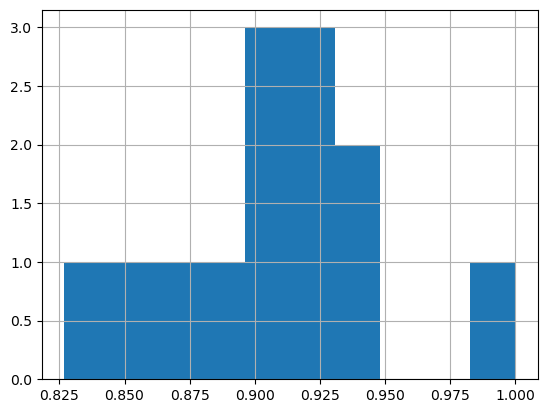

In [351]:
# looking much better now

dose_missing_df.filter(regex="_frac").apply(sum,axis=1).hist()

In [353]:
# dose_missing_df.filter(regex="(_frac)|(country_code)")
dose_light_combined = dose_light_combined.merge(dose_missing_df.filter(regex="(_frac)|(country_code)|(grp_usd_2015_)"),left_on="gid_0",right_on="country_code",how="left")

In [354]:
dose_light_combined.columns

Index(['country', 'gid_0', 'gid_1', 'grp_usd_2015', 'services_usd_2015',
       'manufacturing_usd_2015', 'agriculture_usd_2015', 'country_code',
       'grp_usd_2015_', 'services_frac', 'manufacturing_frac',
       'agriculture_frac'],
      dtype='object')

In [355]:
dose_light_combined.tail(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,grp_usd_2015_,services_frac,manufacturing_frac,agriculture_frac
1787,"Yemen, Rep.",NaN,NaN,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09,NaN,NaN,NaN,NaN,NaN
1788,Zambia,NaN,NaN,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09,NaN,NaN,NaN,NaN,NaN
1789,Zimbabwe,NaN,NaN,1.996312e+10,1.170858e+10,4.463433e+09,1.653794e+09,NaN,NaN,NaN,NaN,NaN


In [359]:
missing_agriculture = dose_light_combined[dose_light_combined["agriculture_usd_2015"].isna()].index
missing_services = dose_light_combined[dose_light_combined["services_usd_2015"].isna()].index
missing_manufacturing = dose_light_combined[dose_light_combined["manufacturing_usd_2015"].isna()].index

missing_grp = dose_light_combined[dose_light_combined["grp_usd_2015"].isna()].index

In [360]:
missing_grp

Index([132, 865, 1206, 1554, 1568, 1594, 1614, 1649, 1707, 1751, 1782], dtype='int64')

In [361]:
dose_light_combined.loc[missing_agriculture,"agriculture_usd_2015"] = dose_light_combined.loc[missing_agriculture,"agriculture_frac"]*dose_light_combined.loc[missing_agriculture,"grp_usd_2015"]

dose_light_combined.loc[missing_manufacturing,"manufacturing_usd_2015"] = dose_light_combined.loc[missing_manufacturing,"manufacturing_frac"]*dose_light_combined.loc[missing_manufacturing,"grp_usd_2015"]

dose_light_combined.loc[missing_services,"services_usd_2015"] = dose_light_combined.loc[missing_services,"services_frac"]*dose_light_combined.loc[missing_services,"grp_usd_2015"]

# dose_light_combined.loc[missing_grp,"grp_usd_2015"] = dose_light_combined.loc[missing_services,"grp_usd_2015_"]

In [362]:
dose_light_combined.iloc[missing_grp]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,grp_usd_2015_,services_frac,manufacturing_frac,agriculture_frac
132,Canada,CAN,CAN.5_1,NaN,NaN,NaN,NaN,CAN,1.556509e+12,0.670010,0.244157,0.018698
865,Philippines,PHL,PHL.109_1,NaN,NaN,NaN,NaN,PHL,3.064459e+11,0.585215,0.304820,0.109965
1206,Tanzania,TZA,None,NaN,NaN,NaN,NaN,TZA,4.741392e+10,0.404312,0.244874,0.267459
1554,British Virgin Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,Channel Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1594,Eritrea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1614,Gibraltar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649,"Korea, Dem. People's Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1707,Not classified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,St. Martin (French part),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
dose_light_combined = dose_light_combined.drop(columns=["country_code","country",*[x for x in dose_light_combined.columns if re.search(string = x,pattern="(_frac)|(_2015_)")]])

In [365]:
# still some NAs
print(dose_light_combined.loc[dose_light_combined.isna().any(axis=1)].shape)

dose_light_combined.loc[dose_light_combined.isna().any(axis=1)].dropna(subset=["grp_usd_2015",*indicator_columns],thresh=3,axis=0)

(272, 6)


,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
1524,NaN,NaN,1.913422e+10,1.018616e+10,4.233263e+09,3.948217e+09
1525,NaN,NaN,8.992957e+11,4.854947e+11,2.265433e+11,1.155662e+11
1526,NaN,NaN,7.693673e+11,4.108969e+11,1.767360e+11,1.557361e+11
1527,NaN,NaN,1.138685e+10,5.270341e+09,2.478198e+09,2.252344e+09
1528,NaN,NaN,1.874939e+11,9.770374e+10,6.141643e+10,1.974833e+10
...,...,...,...,...,...,...
1785,NaN,NaN,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1786,NaN,NaN,7.535966e+13,4.838683e+13,2.021563e+13,3.172975e+12
1787,NaN,NaN,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1788,NaN,NaN,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


In [366]:
print(dose_light_combined.shape)

(1790, 6)


## Validations
Running some tests on the data to identify problems

In [367]:
# dose_light.head(3)
wdi_gdf.head(3)

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Africa Eastern and Southern,AFE,1.155662e+11,8.992957e+11,1498.805084,2.265433e+11,4.854947e+11
2,Africa Western and Central,AFW,1.557361e+11,7.693673e+11,1882.518808,1.767360e+11,4.108969e+11


In [368]:
val = (dose_light[["gid_0","grp_usd_2015"]]
    .groupby("gid_0").sum()
    .merge(wdi_gdf[["country","country_code","grp_usd_2015"]],how="left",left_on="gid_0",right_on="country_code",suffixes=("_dose","_wdi")))
val

,grp_usd_2015_dose,country,country_code,grp_usd_2015_wdi
0,1.138692e+10,Albania,ALB,1.138685e+10
1,6.470000e+08,NaN,NaN,NaN
2,4.105693e+11,Argentina,ARG,5.947493e+11
3,1.220506e+12,Australia,AUS,1.351769e+12
4,3.818610e+11,Austria,AUT,3.819711e+11
...,...,...,...,...
69,8.502612e+10,Ukraine,UKR,9.103097e+10
70,1.812635e+13,United States,USA,1.829502e+13
71,7.408962e+10,Uzbekistan,UZB,8.619626e+10
72,2.224252e+11,Viet Nam,VNM,2.392583e+11


<Axes: >

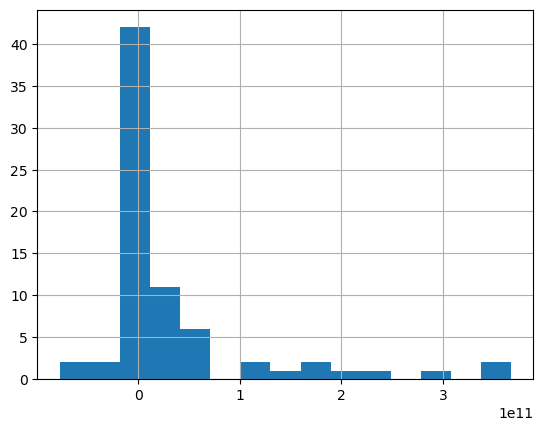

In [369]:
(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"]).hist(bins=15) # .apply(np.log1p)

<Axes: >

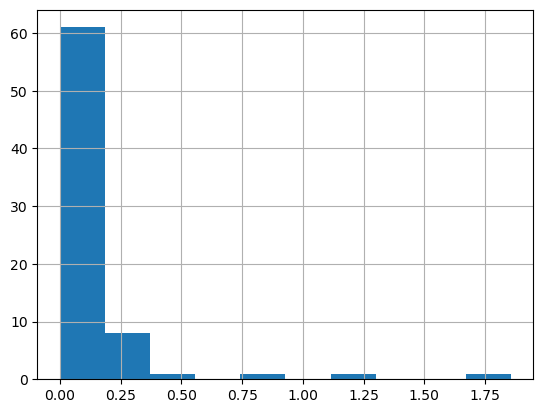

In [370]:
abs_diff = (np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"])#.isna()#.hist(bins=15)

abs_diff[abs_diff< 100].hist(bins=10)

In [371]:
val.loc[(np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"]) > .15,]

,grp_usd_2015_dose,country,country_code,grp_usd_2015_wdi
2,4.105693e+11,Argentina,ARG,5.947493e+11
7,4.370948e+10,Bulgaria,BGR,5.081200e+10
10,4.164175e+10,Belarus,BLR,5.645489e+10
17,2.547149e+11,Colombia,COL,2.934924e+11
20,2.574787e+11,Denmark,DNK,3.026731e+11
24,1.940502e+10,Estonia,EST,2.289076e+10
25,1.829793e+11,Finland,FIN,2.345344e+11
33,1.755689e+12,India,IND,2.103588e+12
34,1.023588e+11,Ireland,IRL,2.923642e+11
39,5.831810e+10,Kenya,KEN,7.012045e+10


In [372]:
# import os

# filename_dose_light = "datasets/local_data/dose_light_combined.csv"

# if os.path.exists(filename_dose_light):
#     print(Warning("File already exists, erase before if you want to regenerate"))
#     # dose_light_combined.to_csv()
# else: 
#     print(f"Writing file locally to '{filename_dose_light}'.")
#     dose_light_combined.to_csv(filename_dose_light,index=False)

Writing file locally to 'datasets/local_data/dose_light_combined.csv'.


OSError: Cannot save file into a non-existent directory: 'datasets/local_data'

### Reading the local file

In [ ]:
# if os.path.exists(filename_dose_light):
#     print("Reading local file")
#     dose_light_combined = pd.read_csv(filename_dose_light)
# else :
#     raise IOError("Could find file.")

In [ ]:
print(dose_light_combined.shape)
dose_light_combined.head(3)

In [373]:
dose_light_combined.loc[dose_light_combined["services_usd_2015"].isna()]

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
132,CAN,CAN.5_1,NaN,NaN,NaN,NaN
779,ANT,BES.1_1,4.660000e+08,NaN,NaN,NaN
780,ANT,BES.2_1,4.700000e+07,NaN,NaN,NaN
781,ANT,BES.3_1,1.340000e+08,NaN,NaN,NaN
865,PHL,PHL.109_1,NaN,NaN,NaN,NaN
1206,TZA,None,NaN,NaN,NaN,NaN
1529,NaN,NaN,6.730000e+08,NaN,NaN,NaN
1554,NaN,NaN,NaN,NaN,NaN,NaN
1568,NaN,NaN,NaN,NaN,NaN,NaN
1594,NaN,NaN,NaN,NaN,NaN,NaN


In [374]:
print((dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015"]).shape[0])/dose_light_combined.shape[0])

dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015"]).head(5)

0.993854748603352


,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08


In [375]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["services_usd_2015"])

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...
1761,NaN,NaN,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1762,NaN,NaN,7.535966e+13,4.838683e+13,2.021563e+13,3.172975e+12
1763,NaN,NaN,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1764,NaN,NaN,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


In [376]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["manufacturing_usd_2015"])

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...
1763,NaN,NaN,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1764,NaN,NaN,7.535966e+13,4.838683e+13,2.021563e+13,3.172975e+12
1765,NaN,NaN,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1766,NaN,NaN,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


In [ ]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["agriculture_usd_2015"])

## H3 with duckdb

testing the duckdb h3 extension to potentially transfer all the projection on the db side for better performance.

In [ ]:
res = conn.raw_sql("""INSTALL h3 FROM community;
                   LOAD h3;""").df()

res

In [ ]:

conn.sql("SELECT h3_cell_to_latlng('822d57fffffffff');")

conn.sql("SELECT h3_cell_to_boundary_wkt('822d57fffffffff');")